In [2]:
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import talib
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num

In [43]:
# Get today's date as UTC timestamp
today = datetime.today().strftime("%d/%m/%Y")
today = datetime.strptime(today + " +0000", "%d/%m/%Y %z")
to = int(today.timestamp())
# Get date ten years ago as UTC timestamp
ten_yr_ago = today-relativedelta(days=200)
fro = int(ten_yr_ago.timestamp())
print(to)
print(fro)

1601596800
1584316800


In [44]:
def get_price_hist(ticker):

    # Put stock price data in dataframe
    url = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={fro}&period2={to}&interval=1d&events=history"
    data = pd.read_csv(url)
    
    # Convert date to timestamp and make index
    data.index = data["Date"].apply(lambda x: pd.Timestamp(x))
    data.drop("Date", axis=1, inplace=True)

    return data

In [14]:
nflx_df = get_price_hist("NFLX")
nflx_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-10-04,21.860001,22.684286,21.652857,22.341429,22.341429,47406800
2010-10-05,22.785715,22.858572,22.030001,22.308571,22.308571,41052900
2010-10-06,22.070000,22.678572,21.208570,21.467142,21.467142,47487300
2010-10-07,21.524286,22.012857,21.262857,21.632856,21.632856,28767900
2010-10-08,21.719999,21.857143,21.150000,21.377142,21.377142,24377500
...,...,...,...,...,...,...
2020-09-25,474.390015,484.869995,468.029999,482.880005,482.880005,3769400
2020-09-28,489.109985,492.000000,477.880005,490.649994,490.649994,4773500
2020-09-29,489.500000,496.290009,486.529999,493.480011,493.480011,3541500


In [42]:
def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['Close'])
    
    # Get MA10 and MA30
    data["ma10"] = talib.MA(data["Close"], timeperiod=10)
    data["ma30"] = talib.MA(data["Close"], timeperiod=30)
    
    # Get RSI
    data["rsi"] = talib.RSI(data["Close"])
    return data
nflx_df2 = get_indicators(nflx_df)
#print(nflx_df2)
print(nflx_df2)#.loc[:,'rsi'][-1])


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-10-04   21.860001   22.684286   21.652857   22.341429   22.341429   
2010-10-05   22.785715   22.858572   22.030001   22.308571   22.308571   
2010-10-06   22.070000   22.678572   21.208570   21.467142   21.467142   
2010-10-07   21.524286   22.012857   21.262857   21.632856   21.632856   
2010-10-08   21.719999   21.857143   21.150000   21.377142   21.377142   
...                ...         ...         ...         ...         ...   
2020-09-25  474.390015  484.869995  468.029999  482.880005  482.880005   
2020-09-28  489.109985  492.000000  477.880005  490.649994  490.649994   
2020-09-29  489.500000  496.290009  486.529999  493.480011  493.480011   
2020-09-30  492.570007  504.630005  489.269989  500.029999  500.029999   
2020-10-01  506.029999  529.549988  503.600006  527.510010  527.510010   

              Volume      macd  macd_

In [10]:
def plot_chart(data, n, ticker):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index, data["ma10"], label="MA10")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.plot(data.index, data["macd"], label="macd")
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["macd_signal"], label="signal")
    ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel("(%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["rsi"], label="rsi")
    ax_rsi.legend()
    
    # Show volume in millions
    ax_vol.bar(data.index, data["Volume"] / 1000000)
    ax_vol.set_ylabel("(Million)")
   
    # Save the chart as PNG
    #fig.savefig("charts/" + ticker + ".png", bbox_inches="tight")
    
    plt.show()

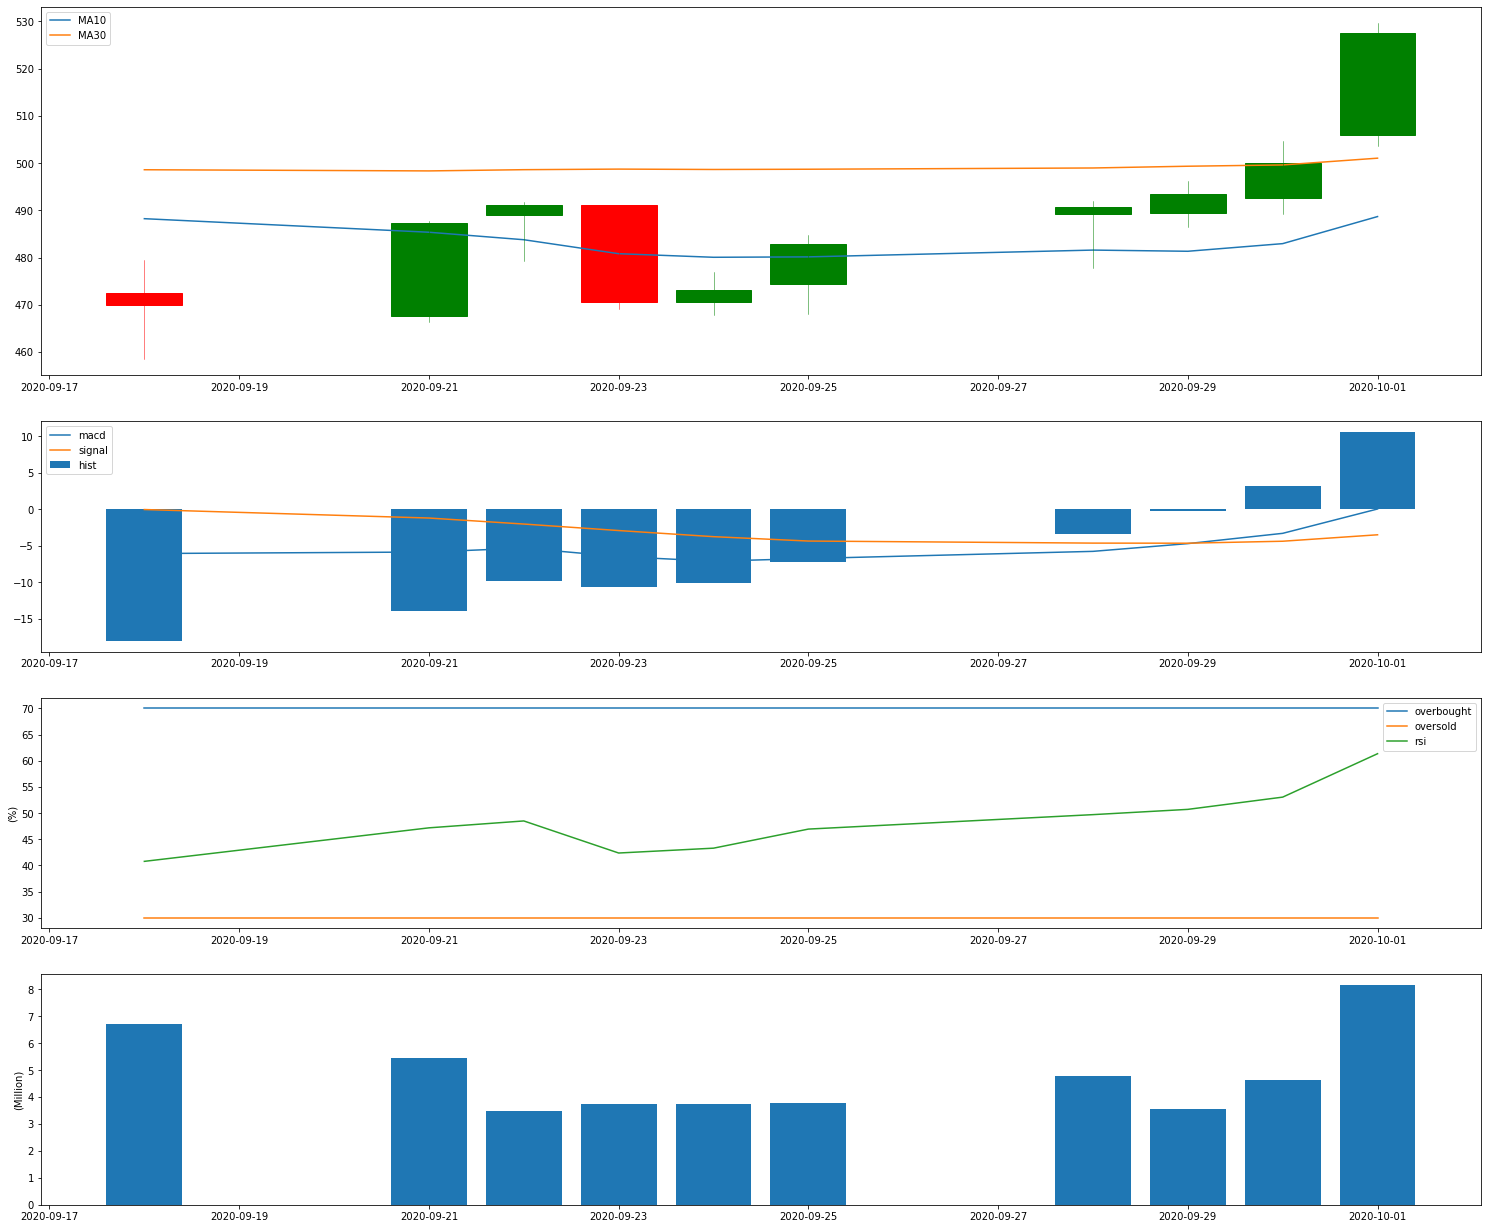

In [13]:
plot_chart(nflx_df2, 10, "NFLX")